# Finetuning Phi2 on custom riddle dataset

In [1]:
# packages 
!pip install -U accelerate peft transformers einops datasets bitsandbytes --q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.3.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.1.4 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2024.1.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2024.1.0 which is incompatible.
dask-cuda 23.8.0 require

In [2]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes" 

accelerate==0.26.1
bitsandbytes==0.42.0
datasets==2.16.1
einops==0.7.0
peft==0.8.2
tensorflow-datasets==4.9.4
transformers==4.37.2


In [3]:
# seed 
from transformers import set_seed
set_seed(42)

2024-02-04 09:41:10.371806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 09:41:10.371906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 09:41:10.534672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Model and Tokenizer

### Loading Model in 4bit

In [4]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# model
model_path = 'microsoft/phi-2'
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map = 'auto',
    quantization_config = BitsAndBytesConfig(
        load_in_4bit =True,
        bnb_4bit_compute_dtype = torch.bfloat16,
        bnb_4bit_quant_type = 'nf4'
    ),
    torch_dtype = torch.bfloat16,
)

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

## Tokenizer

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast = False)


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
len(tokenizer)

50295

### Add ChatML tokens to tokenizer

In [8]:
tokenizer.add_tokens(['<|im_start|>', "<PAD>"])
tokenizer.pad_token = '<PAD>'
tokenizer.add_special_tokens(dict(eos_token = '<|im_end|>'))
model.config.eos_token_id = tokenizer.eos_token_id

Note: there is no need to rezise the token embeddings, phi-2 already has embeddings sized for additional tokens. The model's vocab. size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings.

In [9]:
model.model.embed_tokens

Embedding(51200, 2560)

### Prepare LoRA adapters

In [10]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing = True)

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 32,
    target_modules = ['q_proj','k_proj','v_proj','dense'],
    modules_to_save = ['lm_head','embed_tokens'],
    lora_dropout = 0.1,
    bias = 'none',
    task_type = 'CAUSAL_LM'
)

model = get_peft_model(model, lora_config)
model.config.use_cache = False

### Load and Preprocess dataset

In [11]:
from datasets import load_dataset

dataset = load_dataset('Aditya685/riddles_improved_v2')
dataset = dataset['train'].train_test_split(test_size =0.1)

Generating train split:   0%|          | 0/908 [00:00<?, ? examples/s]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 817
    })
    test: Dataset({
        features: ['number', 'messages'],
        num_rows: 91
    })
})

In [13]:
dataset['train'][0]

{'number': 142,
 'messages': ["A word of three letters long, which, spoken after 'how,' describes how a rabbit hops.",
  'The answer to this riddle is the word "hop." When you say "how a rabbit hops," the word that describes the way a rabbit moves in short bursts is "hop." Therefore, the word that completes the sentence and follows "how" is "hop."\n\nIf you have any questions about the answer or need further clarification, please let me know.',
  "So, 'hop' is the answer and it's how rabbits move? But, how do birds fly? What's the word that comes after 'how' for that?",
  'The word that comes after "how" to describe how birds fly is "fly." Birds are able to move through the air by flapping their wings, which allows them to generate lift and stay aloft. The word "fly" is the verb that describes this action.\n\nSo, to summarize:\n\n* "How a rabbit hops?" - Answer: "hop"\n* "How a bird flies?" - Answer: "fly"\n\nI hope this helps clarify any confusion. Let me know if you have any other qu

### Apply ChatML format and tokenize


In [14]:
import os
from functools import partial

# Format (ChatML) and tokenize dataset
templates = [
    '<|im_start|>assistant\n{msg}<|im_end|>',
    '<|im_start|>user\n{msg}<|im_end|>'
]

IGNORE_INDEX = -100

def tokenize(input, max_length):
    input_ids, attention_mask , labels = [], [], []
    
    for i , msg in enumerate(input['messages']):
        isHuman = i%2 == 0
        msg_chatml = templates[isHuman].format(msg = msg)
        msg_tokenized = tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+= msg_tokenized['input_ids']
        attention_mask+= msg_tokenized['attention_mask']
        labels+= [IGNORE_INDEX] * len(msg_tokenized['input_ids']) if isHuman else msg_tokenized['input_ids']

    return {
        'input_ids' : input_ids[:max_length],
        'attention_mask' : attention_mask[:max_length],
        'labels': labels[:max_length]
    }



dataset_tokenized = dataset.map(
    partial(tokenize, max_length = 1024), # max sample length 1024 tokens, enough for this dataset
    batched = False,
    num_proc = os.cpu_count(), # multithreaded
    remove_columns = dataset['train'].column_names # don't need this anymore

)

Map (num_proc=4):   0%|          | 0/817 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/91 [00:00<?, ? examples/s]

In [15]:
dataset_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 817
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 91
    })
})

longest sample: 878 tokens


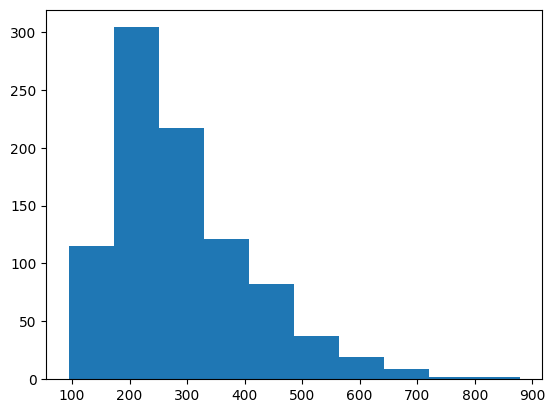

In [16]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])] 
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)  
plt.show()


### Define a collate function,train on answers only



In [17]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_id}

def collate(elements):
    tokens = [e['input_ids'] for e in elements]
    tokens_maxlen = max([len(t) for t  in tokens])

    for i, sample in enumerate(elements):
        input_ids = sample['input_ids']
        labels = sample['labels']
        attention_mask = sample['attention_mask']

        pad_len = tokens_maxlen - len(input_ids)

        input_ids.extend(pad_len * [tokenizer.pad_token_id])
        labels.extend(pad_len * [IGNORE_INDEX])
        attention_mask.extend(pad_len * [0])

    batch = {
        'input_ids' : torch.tensor([e['input_ids'] for e in elements]),
        'labels' : torch.tensor([e['labels'] for e in elements]),
        'attention_mask' : torch.tensor([e['attention_mask'] for e in elements])

    }

    return batch


## Train

#### Set Hyperparameters

In [18]:
from transformers import TrainingArguments, Trainer

# dataset- specific parameters
bs = 1 # batch size for training
bs_eval = 16 # batch size for evaluation
ga_steps = 16 # gradient accumulation steps
lr = 0.00002 # learning rate

epochs = 3

steps_per_epoch = len(dataset_tokenized['train']) // (bs * ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=20,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=False,        
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)


In [19]:
# wandb project
import wandb
run = wandb.init(
    project = 'phi2',
    name = 'testrunkaggle'
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.569700,1.293707
50,1.425300,1.125321
75,1.202900,1.002538
100,0.986600,0.910008
125,0.871200,0.875669
150,0.824500,0.862401


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=153, training_loss=1.1094477597404928, metrics={'train_runtime': 5545.7838, 'train_samples_per_second': 0.442, 'train_steps_per_second': 0.028, 'total_flos': 1.19029468658688e+16, 'train_loss': 1.1094477597404928, 'epoch': 3.0})

In [23]:
import gc
import torch
# del model

gc.collect()
gc.collect()
torch.cuda.empty_cache()

In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

# base model
base_path = 'microsoft/phi-2'

# adapters: path to folder with adapter_model.safetensors
adapter_path = 'out/checkpoint-153'

# model dir
save_to = 'trained_model'

# load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype = torch.bfloat16,
    device_map = 'auto'
)

tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

# Add ChatML template to tokenizer
tokenizer.chat_template="{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

base_model.config.eos_token_id = tokenizer.eos_token_id

# Set a default Generation configuration: Llama precise
generation_config = GenerationConfig(
    max_new_tokens=100, 
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)
generation_config.save_pretrained(save_to)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
import gc
import torch
# del model
# del base_model

gc.collect()
gc.collect()
torch.cuda.empty_cache()

### Inference from trained model


In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

model_path="trained_model"    
question="Hello, who are you?"

model = AutoModelForCausalLM.from_pretrained(
        model_path,    
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
tokenizer = AutoTokenizer.from_pretrained(model_path) 

messages=[
    {"role": "user", "content": question}
]
        
input_tokens = tokenizer.apply_chat_template(
    messages, 
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

output_tokens = model.generate(input_tokens)
output = tokenizer.decode(
    output_tokens[0][len(input_tokens[0]):],
    skip_special_tokens=True
    )               

print(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


I am an AI language model. I don't have a physical form or the ability to ask questions directly from users. However, I can help answer any questions related to my capabilities and functions based on the information provided in the previous messages. If there's anything specific you'd like me to clarify about my abilities as an AI language model, please let me know!


In [32]:
def response(question):
    messages=[
    {"role": "user", "content": question}
    ]
        
    input_tokens = tokenizer.apply_chat_template(
        messages, 
        add_generation_prompt=True,
        return_tensors="pt"
    ).to("cuda")

    output_tokens = model.generate(input_tokens)
    output = tokenizer.decode(
        output_tokens[0][len(input_tokens[0]):],
        skip_special_tokens=True
        )               

    return output

In [35]:
response('what is cloud computing?')

'Cloud computing refers to the delivery of various services, including storage, processing power, and software applications over the internet. Instead of relying on local servers or personal computers, users can access these resources remotely through a network connection. This allows for greater flexibility, scalability, and cost-effectiveness compared to traditional on-premises solutions. Some common examples of cloud computing include online email providers like Gmail, file sharing platforms like Dropbox, and virtual private networks (VPNs) that allow secure remote access to'

In [36]:
response('Do you know about OpenAI')

'Yes, I am aware of OpenAI. It is an artificial intelligence research and development company that was founded in 2015 by Elon Musk, Sam Altman, Ilya Sutskever, Greg Brockman, and Shane Legg. The goal of OpenAI is to develop AI systems that can benefit humanity while also ensuring their safety and avoiding any potential risks or negative consequences. They have several projects focused on natural language processing (NLP), computer vision, reinforcement learning, and other areas of AI research'

In [39]:
!pip install --upgrade huggingface_hub --q

In [40]:
from huggingface_hub import login
login()

In [41]:
model.push_to_hub("Aditya685/phi-2_riddles-evolved_epoch3")
tokenizer.push_to_hub("Aditya685/phi-2_riddles-evolved_epoch3")

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Aditya685/phi-2_riddles-evolved_epoch3/commit/af30eb0d946f783af978016bf4d2430b5cea312e', commit_message='Upload tokenizer', commit_description='', oid='af30eb0d946f783af978016bf4d2430b5cea312e', pr_url=None, pr_revision=None, pr_num=None)